In [1]:
%%capture

# cd ...  ==> to where this script is situated

# MAC
#cd Users/romybeaute/Desktop/MCP_pipeline/automatized_reports

#LINUX
# cd Bureau/MCP_pipeline/automatized_reports
#jupyter nbconvert --to pdf --TemplateExporter.exclude_input=True  MCP_reports.ipynb --output -MCP_report.pdf

#visualisation parameters (for notebook)
%matplotlib inline
import warnings
import IPython
import numpy
import matplotlib
import seaborn
import sklearn
import pandas
import tqdm
import mne  # https://github.com/mne-tools/mne-python
import pycsd  # https://github.com/nice-tools/pycsd
import os
import time
import pickle
import csv
import nbconvert
import math

for package in (IPython, numpy, matplotlib, seaborn, sklearn, pandas, mne, pycsd):
    print(package.__name__, ': ', package.__version__)

# Functions from jupyter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore matplotllib warnings
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

from pandas import DataFrame
from tqdm import notebook

from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.model_selection import cross_val_predict, cross_val_score, LeaveOneGroupOut

from mne.channels import montage
from mne.channels.montage import *
from mne.io import brainvision
from mne.channels._standard_montage_utils import _safe_np_loadtxt as snpl
from mne.channels._standard_montage_utils import _easycap as easycap
#print(raw.info)
#easycap('easycap-M1.txt', head_size=10)

from mne.time_frequency import psd_multitaper
from mne.channels.montage import _read_eeglab_locations,_get_montage_in_head
from mne.decoding import LinearModel, get_coef
from mne import preprocessing
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,corrmap)
from mne.channels._standard_montage_utils import _safe_np_loadtxt


#personal modules
import sys # tells python which folders it should consider for its module search

sys.path.append('../main_functions')

from mapping_functions import diy_change_montage
from automatized_MCP import *
from MCP_vars import *
import configs as cfg

In [5]:
# ==> Parametaters to define
run_imaginev = False #only for controls
run_activev = True #only for controls
permutations = None
lat = ['right','left']
plot = True
change_montage = 19 # can be 4, 8, 19, 128, 256 or None (use None for EGI26 without -self defined- bad chans)
plot_eeg = False #if True, plot the EEG data

In [6]:
# ==> Select specific subject 

#subject_type = input('Subject type : ')
subject_type = 'patients'

subject_id = input('Subject ID : ')

print('Motor Command Protocol report for {} ({})'.format(subject_id,subject_type[:-1]))


# ==> Read Data from Google Sheets into Pandas

sheet_id = '1wvrkO8mHMx-fGP9HrwpBs57iQmEwBpcJ-DdtcfjV0JE'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={subject_type}'
df = pd.read_csv(url)
#df = pd.read_csv('MCP_permed.csv')


# ==> Loading the parameters from the CSV file 
if not df.index.name == 'ID': 
    df.set_index('ID',inplace=True) #change the index if not already done

# ==> Preprocessing parameters
#preproc = ['filt', 'csd', 'ears_outlines', 'chan_to_drop','E257']
fmin, fmax = 1.0, 30.0  # frequency cut-off, in Hz
viz_plot = None
center, setup, filename, filename2, is_control, datapath, filepath, preproc, is_imagine = load_setups(subject_id,df)

Subject ID : JM288
Motor Command Protocol report for JM288 (patient)


# Data preprocessing 

In [7]:
%%capture

# ==> Load & preprocess RAW data
if str(filename2) != 'nan': #recording in 2 separate files : cocatenate them
    files = list([filename,filename2])
    raw = concatenate_rec(datapath,files,preproc,subject_type,center)
else:
    print('Loading data from {}.'.format(filepath))
    raw = read_raw(filepath,preproc)

In [8]:
%%capture
events, events_info, event_dict = get_instructions(raw, df, subject_id, run_imaginev, run_activev)

In [9]:
n_eeg_chans = len(mne.pick_types(raw.info, eeg=True, stim=False))

if change_montage is not None:

    # ==> change montage if needed
    raw.drop_channels(['E257'])
    raw,use_ch = diy_change_montage(raw, nb_eletrodes=change_montage)
    print('Applied a {} --> {} electrodes mapping'.format(n_eeg_chans, change_montage))
    # ==> get rid of bad chans that we defined
else:
    raw = diy_drop_bads(raw,preproc)
    
used_eeg = mne.pick_types(raw.info, eeg=True, stim=False)  # kept eeg chans after preprocessing & remapping
#print('Used chans : ',[raw.info['chs'][i]['ch_name'] for i, p in enumerate(raw.info['chs']) if raw.info['chs'][i]['kind'] == 2])
print('Keeping {} channels over {} after preprocessing steps ({:.1f} %)'.format(len(used_eeg), n_eeg_chans, len(used_eeg) / n_eeg_chans * 100))

Applied a 257 --> 19 electrodes mapping
Keeping 19 channels over 257 after preprocessing steps (7.4 %)


In [10]:
if plot_eeg != False:
    raw.plot()

In [11]:
%%capture
warnings.filterwarnings("ignore", category=DeprecationWarning) 
epochs, metadata = create_epochs(raw, events, events_info, event_dict)

# Block design

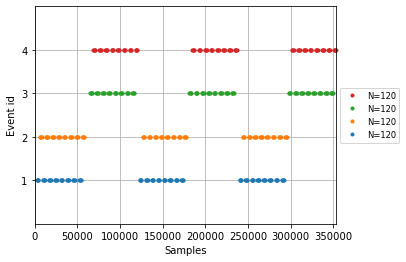

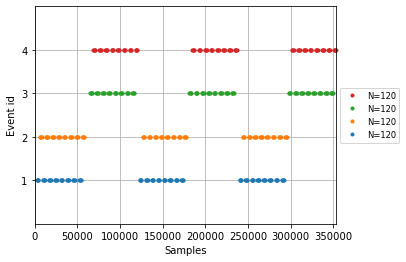

In [12]:
mne.viz.plot_events(events)

In [13]:
print('Code of events: ',event_dict)

if lat != ['right', 'left']: # only one lateralization
    print('Modifying keeping only {} events'.format(lat[0]))
    epochs = epochs['keep/{}'.format(lat[0]), 'stop/{}'.format(lat[0])]
    print('Using {} events.\nUsed epochs : {} '.format(lat[0], epochs))
    metadata = epochs.metadata

Code of events:  {'keep/right': 1, 'stop/right': 2, 'keep/left': 3, 'stop/left': 4}


In [14]:
%%capture

# Compute power spectral densities for each frequency band
full_psd_data, frequencies = psd_multitaper(epochs, fmin=fmin, fmax=fmax)
n_epochs, n_chans, n_freqs = full_psd_data.shape # (160epochs, 60chans, 58freqs)

# Frequency bands of interest, in Hz
bands = ((1, 3), (4, 7), (8, 13), (14, 30))

# Setup X array: average PSD within a given frequency band
psd_data = np.zeros((n_epochs, n_chans, len(bands)))
for ii, (fmin, fmax) in enumerate(bands):
    # Find frequencies
    freq_index = np.where(np.logical_and(frequencies >= fmin,
                                         frequencies <= fmax))[0]
    
    # Mean across frequencies
    psd_data[:, :, ii] = full_psd_data[:, :, freq_index].mean(2)

    
# Vectorize PSD: i.e. matrix of n_trials x (channel x 4 frequency bands)
psd_data = psd_data.reshape(n_epochs, n_chans * len(bands)) #pour chaque epoch : power dans chaque bande de freq par electrode

# Plot cross-validation for verification purposes

In  order  to  prevent  training  the  classifier  on  potentially  temporally-correlated  neighboring  epochs,   we  apply  a  leave  one-trial-out  cross-validation (CV).
Consequently, the training set consists of 2-second long epochs that are nottemporally adjacent to those used during the test set.
We plot it here to verify that it worked correctly.

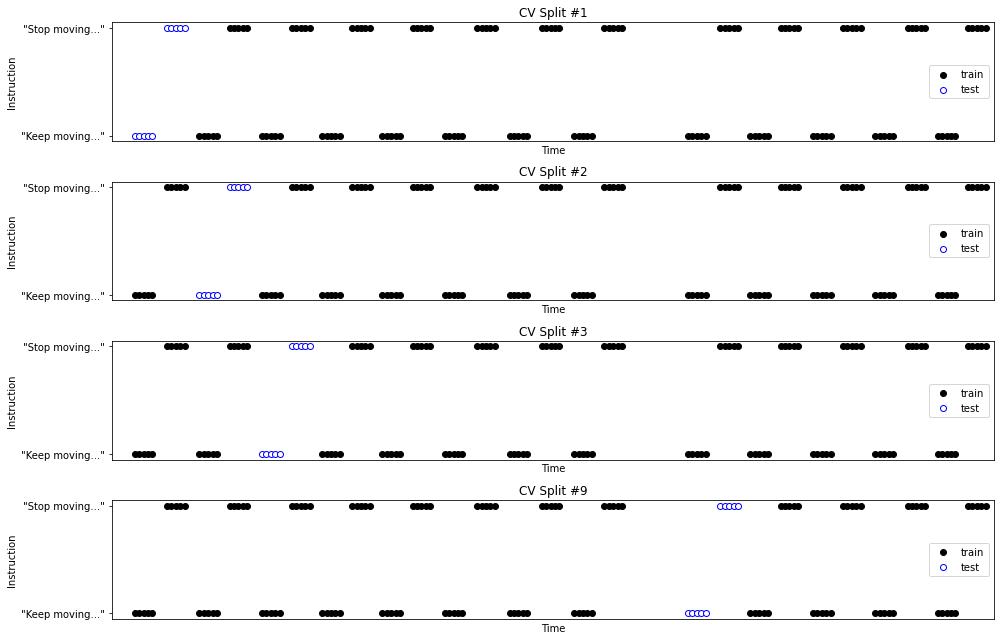

In [15]:
# Define cross validation

cv = LeaveOneGroupOut()
if viz_plot != 0:

    # Here, we plot 4 splits as examples: CV #1, #2, #3 as well as split #9.

    fig, axes = plt.subplots(4, 1, figsize=[14, 9]) #[14, 9]
    axes = iter(axes)

    for split, (train, test) in enumerate(cv.split(
        X=psd_data,                      # The 4 bands of PSD for each channel 
        y=epochs.metadata['move'],       # The epoch category                
        groups=epochs.metadata['trial'], # used to avoid neighboring epochs
    )):

        # Avoid plotting all splits
        if split >= 3 and split != 8:
            continue
        ax = next(axes)

        # Plot train and test epochs sample
        ax.scatter(epochs.metadata['time_sample'].values[train],
                   1-epochs.metadata['move'].values[train],
                   color='k', label='train')
        ax.scatter(epochs.metadata['time_sample'].values[test],
                   1-epochs.metadata['move'].values[test],
                   edgecolor='b', color='w', label='test')
        ax.set_title('CV Split #%i' % (split+1))
        ax.set_yticks([0, 1])
        ax.set_yticklabels(['"Keep moving..."', '"Stop moving..."'])
        ax.set_ylabel('Instruction')
        ax.set_xlabel('Time')
        ax.set_xticks([])
        ax.set_xlim(0, 100000) # zoom for clarity
        ax.legend()
    fig.tight_layout()

# In the first split CV Split #1, trial #1 from bock #1 is used 
# as test set and so one (CV Split #9 uses trial #1 of bolck #2 as test set).

# Decoding performance over time

To visualize how the decoding performs over time, we compute the SVM predicted probability of "keep moving..." over time and plot the average probability across all blocks.
Useful to compare the classifier performance over time between controls, cognitive motor dissociation
(CMD) patients and non CMD patients.


/!\ This plot is for clarity and descriptive purpose only, as it is not the exact same function that has been used to calculate the AUC score /!\

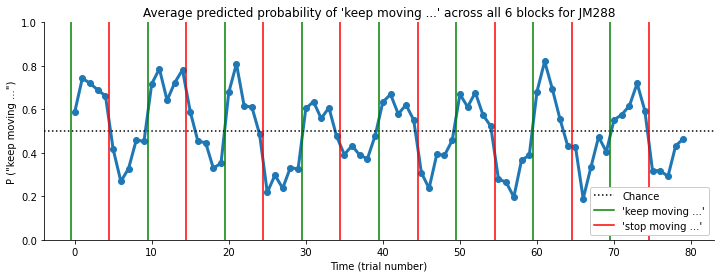

In [16]:
clf = make_pipeline(
    StandardScaler(), #RobustScaler()     # does both normalization and scaling. z-score centers data
    SVC(kernel='linear', probability=True)) # linear SVM to decode two classes

# Define cross validation
cv = LeaveOneGroupOut()

# compute class probabbility for each epoch using the same previously described CV
y_pred = cross_val_predict(
    clf, 
    X=psd_data, 
    y=epochs.metadata['move'],  
    cv=cv, 
    method="predict_proba",
    groups=epochs.metadata['trial']
)
epochs.metadata['y_pred'] = y_pred[:, 1]

# Average the proba over the 3 blocks to obtain the temporal pattern
# ==> len(proba) = nombre de trial per block (avg)

proba = np.mean([block['y_pred'] for _, block in epochs.metadata.groupby('block')],
                axis=0)
nblocks = len(epochs.metadata.groupby('block'))

# plot the proba
fig, ax = plt.subplots(figsize=(12,4))
ax.set_ylabel('P ("keep moving ...")')
ax.set_xlabel('Time (trial number)')
ax.plot(proba, marker='o', linestyle='-',
        linewidth=3, markersize=6)
ax.set_ylim([0.0, 1.0])
plt.axhline(0.5, linestyle=':', color='k', label='Chance')

for x in np.arange(-0.5, 79, 10):
    plt.axvline(x, color='g', label="'keep moving ...'" if x < 4 else None)
    plt.axvline(x + 5., color='r', label="'stop moving ...'" if x < 4 else None) 
plt.legend(loc='lower right', framealpha=1.)
plt.title("Average predicted probability of 'keep moving ...' across all {} blocks for {}".format(nblocks,subject_id))
sns.despine()

# Spatial patterns over the 4 frequency bands

- Visualize and compare the spatial distribution of the spectral information used by the SVM classifier

- Features : n electrodes x 4 frequency bands per epoch

In [17]:
%%capture


clf = make_pipeline(
    StandardScaler(),         # z-score to center data
    LinearModel(LinearSVC())) # Linear SVM augmented with an automatic storing of spatial patterns
    #max_iter=10000
# fit classifier
clf.fit(X=psd_data,
        y=epochs.metadata['move'])
# ==> Retrieve the coefficients of an estimator ending with a Linear Model.
# Unscale the spatial patterns before plotting
patterns = get_coef(clf, 'patterns_', inverse_transform=True)

# In our study, the SVM is trained on all frequencies simultanouesly
# we thus pull the corresponding spatial topographies apart
n_elect = int(patterns.shape[0] / len(bands))
spatial_pattern = patterns.reshape(n_elect, len(bands))

 Spatial patterns over 1 - 3 Hz
 Spatial patterns over 4 - 7 Hz
 Spatial patterns over 8 - 13 Hz
 Spatial patterns over 14 - 30 Hz


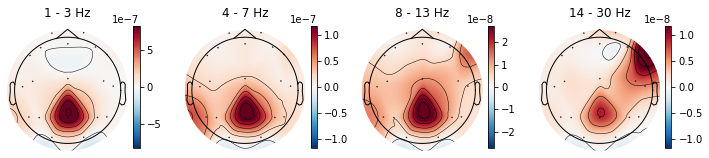

In [18]:

'''
try:
    raw.plot_sensors()
    plt.close()
except:
    print('Setting up the montage : ',raw.info['montage'])
    raw.set_montage(montage=raw.info['montage'])
'''


# ==> use this to scale the SP across subjects (only for group analysis)
#scaler = MinMaxScaler()
#spatial_pattern = scaler.fit_transform(spatial_pattern)


raw.set_montage(montage=raw.info['montage'])
posarray = np.array([raw.info['chs'][i]['loc'][:2].tolist() for i,p in enumerate(raw.info['chs']) if raw.info['chs'][i]['kind'] == 2])
posarray_names = np.array([raw.info['chs'][i]['ch_name'] for i,p in enumerate(raw.info['chs']) if raw.info['chs'][i]['kind'] == 2])

fig, axes = plt.subplots(1, 4,figsize=(10,3)) 
fig.tight_layout()

for idx, (band, sp, ax) in enumerate(zip(bands, spatial_pattern.T,axes)):
    scale = np.percentile(np.abs(sp), 99)
    #scale = np.max(np.abs(sp))
    print(' Spatial patterns over %i - %i Hz' % band)
    im, _ = mne.viz.plot_topomap(sp,
                                 pos=posarray,
                                 ch_type='eeg',
                                 names = posarray_names,
                                 show_names=False,
                                 vmin=-scale, vmax=+scale,
                                 #extrapolate = 'head',
                                 axes=ax, #contours=0,
                                 cmap='RdBu_r', show=False)
    plt.colorbar(im,ax=ax,fraction=0.046, pad=0.04)
    ax.set_title('%i - %i Hz' % band)

plt.show()

In [23]:
%%capture
# Compute Spatial Pattern for all frequency bands

# Spatial patterns over the whole power spectrum
# Visualize and compare the spatial distribution of the spectral information used by
# the SVM classifier

# Setup X array: average PSD for each electrode for each epoch
fpsd_data = np.zeros((n_epochs, n_chans))
for e in range(n_epochs): #for each epoch
    for c in range(n_chans): #for each channel
        fpsd_data[e, c] = np.mean(full_psd_data[e,c]) #shape (n_epochs,n_chans)

# Features : coef per electrodes per epoch : shape = (n_epochs,n_chans)

clf = make_pipeline(
    StandardScaler(),         # z-score to center data
    LinearModel(LinearSVC())) # Linear SVM augmented with an automatic storing of spatial patterns

# fit classifier
clf.fit(X=fpsd_data,
        y=epochs.metadata['move'])

# ==> Retrieve the coefficients of an estimator ending with a Linear Model.
# Unscale the spatial patterns before plotting
fpatterns = get_coef(clf, 'patterns_', inverse_transform=True)

# In our study, the SVM is trained on all frequencies simultanouesly
# we thus pull the corresponding spatial topographies apart
n_elect = int(fpatterns.shape[0])
full_spatial_pattern = fpatterns.reshape(n_elect)



posarray = np.array([raw.info['chs'][i]['loc'][:2].tolist() for i,p in enumerate(raw.info['chs']) if raw.info['chs'][i]['kind'] == 2])
posarray_names = np.array([raw.info['chs'][i]['ch_name'] for i,p in enumerate(raw.info['chs']) if raw.info['chs'][i]['kind'] == 2])

fig.tight_layout()

#scale = np.percentile(np.abs(sp), 99)
#print(' Spatial patterns over %i - %i Hz' % band)
im, _ = mne.viz.plot_topomap(full_spatial_pattern.T,
                             pos=posarray,
                             ch_type='eeg',
                             names = posarray_names,
                             show_names=False,
                             vmin=-scale, vmax=+scale,
                             #extrapolate = 'head',
                             #axes=ax, #contours=0,
                             cmap='RdBu_r', show=False)
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.show()


# Computing cross-validated AUC scores

In [24]:
%%capture
# Set the SVM classifyer with a linear kernel 

clf = make_pipeline(
    StandardScaler(),  # z-score to center data
    LinearSVC()        # Fast implementation of linear support vector machine 
)

# Computes SVM decoding score with cross-validation 
scores = cross_val_score(
    estimator=clf,                   # The SVM 
    X=psd_data,                      # The 4 bands of PSD for each channel 
    y=epochs.metadata['move'],       # The epoch categories                
    scoring='roc_auc',               # Summarize performance with the Area Under the Curve (='roc_a
    cv=cv,                           # The cross-validation scheme
    groups=epochs.metadata['trial'], # use for cv
)
mean_score = scores.mean(0)

In [25]:
print('Mean scores across split: AUC=%.3f' % mean_score)

Mean scores across split: AUC=0.845


# Diagnosis of cognitive motor dissociation (CMD)

## Performing permutation test

To evaluate whether the mean AUC score significantly differs from chance (if AUC > 0.5), we perform a permutation test (Good P. 2006; Noirhomme Q et al. Neuroimage Clin. 2014; Noirhomme et al. Neuroimage. 2017).

This procedure consists of training and evaluating the same classifier several times (n=250 or 500) after randomly shuffling the target labels (i.e. “keep moving …” and “stop moving …”).

A recording is considered to reveal command following (i.e., diagnosis of Cognitive Motor Dissociation in clinically unresponsive patients) if less than 5% of the AUCs obtained with scrambled labels are superior or equal to the mean AUC obtained using the real labels.

In [26]:
%%capture
if mean_score >= 0.50:
    if permutations != None:
        permutation_scores = []
        order = np.arange(len(epochs))
        for _ in tqdm.notebook.tqdm(range(permutations)): #tqdm.notebook.tqdm

            # Shuffle order
            np.random.shuffle(order)

            # Compute score with similar parameters
            permutation_score = cross_val_score(
                estimator=clf,
                X=psd_data,
                y=epochs.metadata['move'].values[order],
                scoring='roc_auc',
                cv=cv,
                groups=epochs.metadata['trial'].values[order],
                n_jobs=-1,  # multiple core
            )

            # Store results
            permutation_scores.append(permutation_score.mean(0))

In [27]:
# The p-value is computed from the number of permutations which 
#leads to a higher score than the one obtained without permutation
# p = n_higher + 1 / (n_permutation + 1)
if permutations != None: 
    try:

        n_higher = sum([s >= scores.mean(0) for s in permutation_scores])
        pvalue = (n_higher + 1.) / (permutations + 1.)

        print('Performed %i permutations'% permutations)
        print("Empirical AUC = %.2f +/-%.2f" % (scores.mean(0), scores.std(0)))
        print("Shuffle AUC = %.2f" % np.mean(permutation_scores, 0))
        print("p-value = %.4f" % pvalue)

        # plot permutation and empirical distributions
        sns.kdeplot(permutation_scores, label='permutation scores')
        sns.kdeplot(scores)

        plt.axvline(.5, linestyle='--', label='theoretical chance')
        plt.axvline(scores.mean(), color='orange', label='mean score')
        plt.scatter(scores, 6. + np.random.randn(len(scores))/10., color='orange',
                    s=5, label='split score')
        plt.xlim(-.1, 1.1)

        plt.legend()
        plt.xlabel('AUC Score')
        plt.ylabel('Probability')
        plt.yticks([])
        plt.show()
        
    except:
        pass
else:
    pvalue = "Nan"
    pass

# Interpretability of the results

In [28]:
if mean_score >= 0.50:
    
    if pvalue != 'Nan':
        
        if pvalue < 0.05:
            print('Presence of significative variation in brain activity in response to alternative verbal motor instructions (“keep moving …” and “stop moving …”) : \n AUC={0:.2f} (p={1:.2f})'.format(mean_score,pvalue))
        
        else:
            print('Absence of significative variation in brain activity in response to alternative verbal motor instructions (“keep moving …” and “stop moving …”) : \n AUC={0:.2f} (p={1:.2f})'.format(mean_score,pvalue))
    
    else:
        print('Presence of variation in brain activity in response to alternative verbal motor instructions (“keep moving …” and “stop moving …”) : \n AUC={0:.2f} (p= Not defined, run it to be confident about the result)'.format(mean_score))
        
else:
    print('Absence of variation in brain activity in response to alternative verbal motor instructions (“keep moving …” and “stop moving …”) : \n AUC={0:.2f}'.format(mean_score))
    

Presence of variation in brain activity in response to alternative verbal motor instructions (“keep moving …” and “stop moving …”) : 
 AUC=0.85 (p= Not defined, run it to be confident about the result)
